# Lab meeting 2018-10-01

In [1]:
import os
import sys
from pathlib import Path
import datetime

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from dask import delayed
from dask.distributed import Client as DaskClient

# Project level imports
sys.path.insert(0, '../lib')
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook()

Please check output/fbgn2chrom.tsv. If it does not exist, run bin/fbgn2chrom.py
last updated: 2018-09-30 
Git hash: e661446c073541ec5d8ce0ef424e3221bd0e4094


In [3]:
# Connect to data store
store = pd.HDFStore('../output/sra.h5', mode='r')

In [21]:
# Set of figures
mpl.rcParams['figure.figsize'] = 7, 7
mpl.rcParams['figure.titlesize'] = 12
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.size'] = 12
mpl.rcParams['grid.linewidth'] = 1.3
mpl.rcParams['legend.fontsize'] = 8.0
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 11
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markeredgewidth'] = 0.02
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['patch.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 10.0
mpl.rcParams['xtick.major.pad'] = 9.1
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.labelsize'] = 10.0
mpl.rcParams['ytick.major.pad'] = 9.1
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 1

In [5]:
from pymongo import MongoClient
try:
    with open('../output/.mongodb_host', 'r') as fh:
        host = fh.read().strip()
except FileNotFoundError:
    host = 'localhost'

mongoClient = MongoClient(host=host, port=27017)
db = mongoClient['sra']
ncbi = db['ncbi']

In [6]:
daskClient = DaskClient()
daskClient

In [8]:
complete = store['aln/complete'].srx.unique().tolist()

In [9]:
len(complete)

27141

In [10]:
libstrat = pd.DataFrame(list(ncbi.aggregate([
    {
        '$project': {
            '_id': 0,
            'srx': '$_id',
            'library_strategy': '$sra.experiment.library_strategy'
        }
    }
])))

libstrat.set_index('srx', inplace=True)

In [11]:
libstrat.library_strategy.reindex(complete).value_counts().map(lambda x: f'{x:,}').to_frame()

,library_strategy
RNA-Seq,"14,423"
EST,"4,546"
ChIP-Seq,"3,003"
OTHER,"2,572"
WGS,"1,972"
miRNA-Seq,131
MNase-Seq,116
Targeted-Capture,96
AMPLICON,86
ncRNA-Seq,69


Text(0.5,1,'Distribution of Percent Stranded')

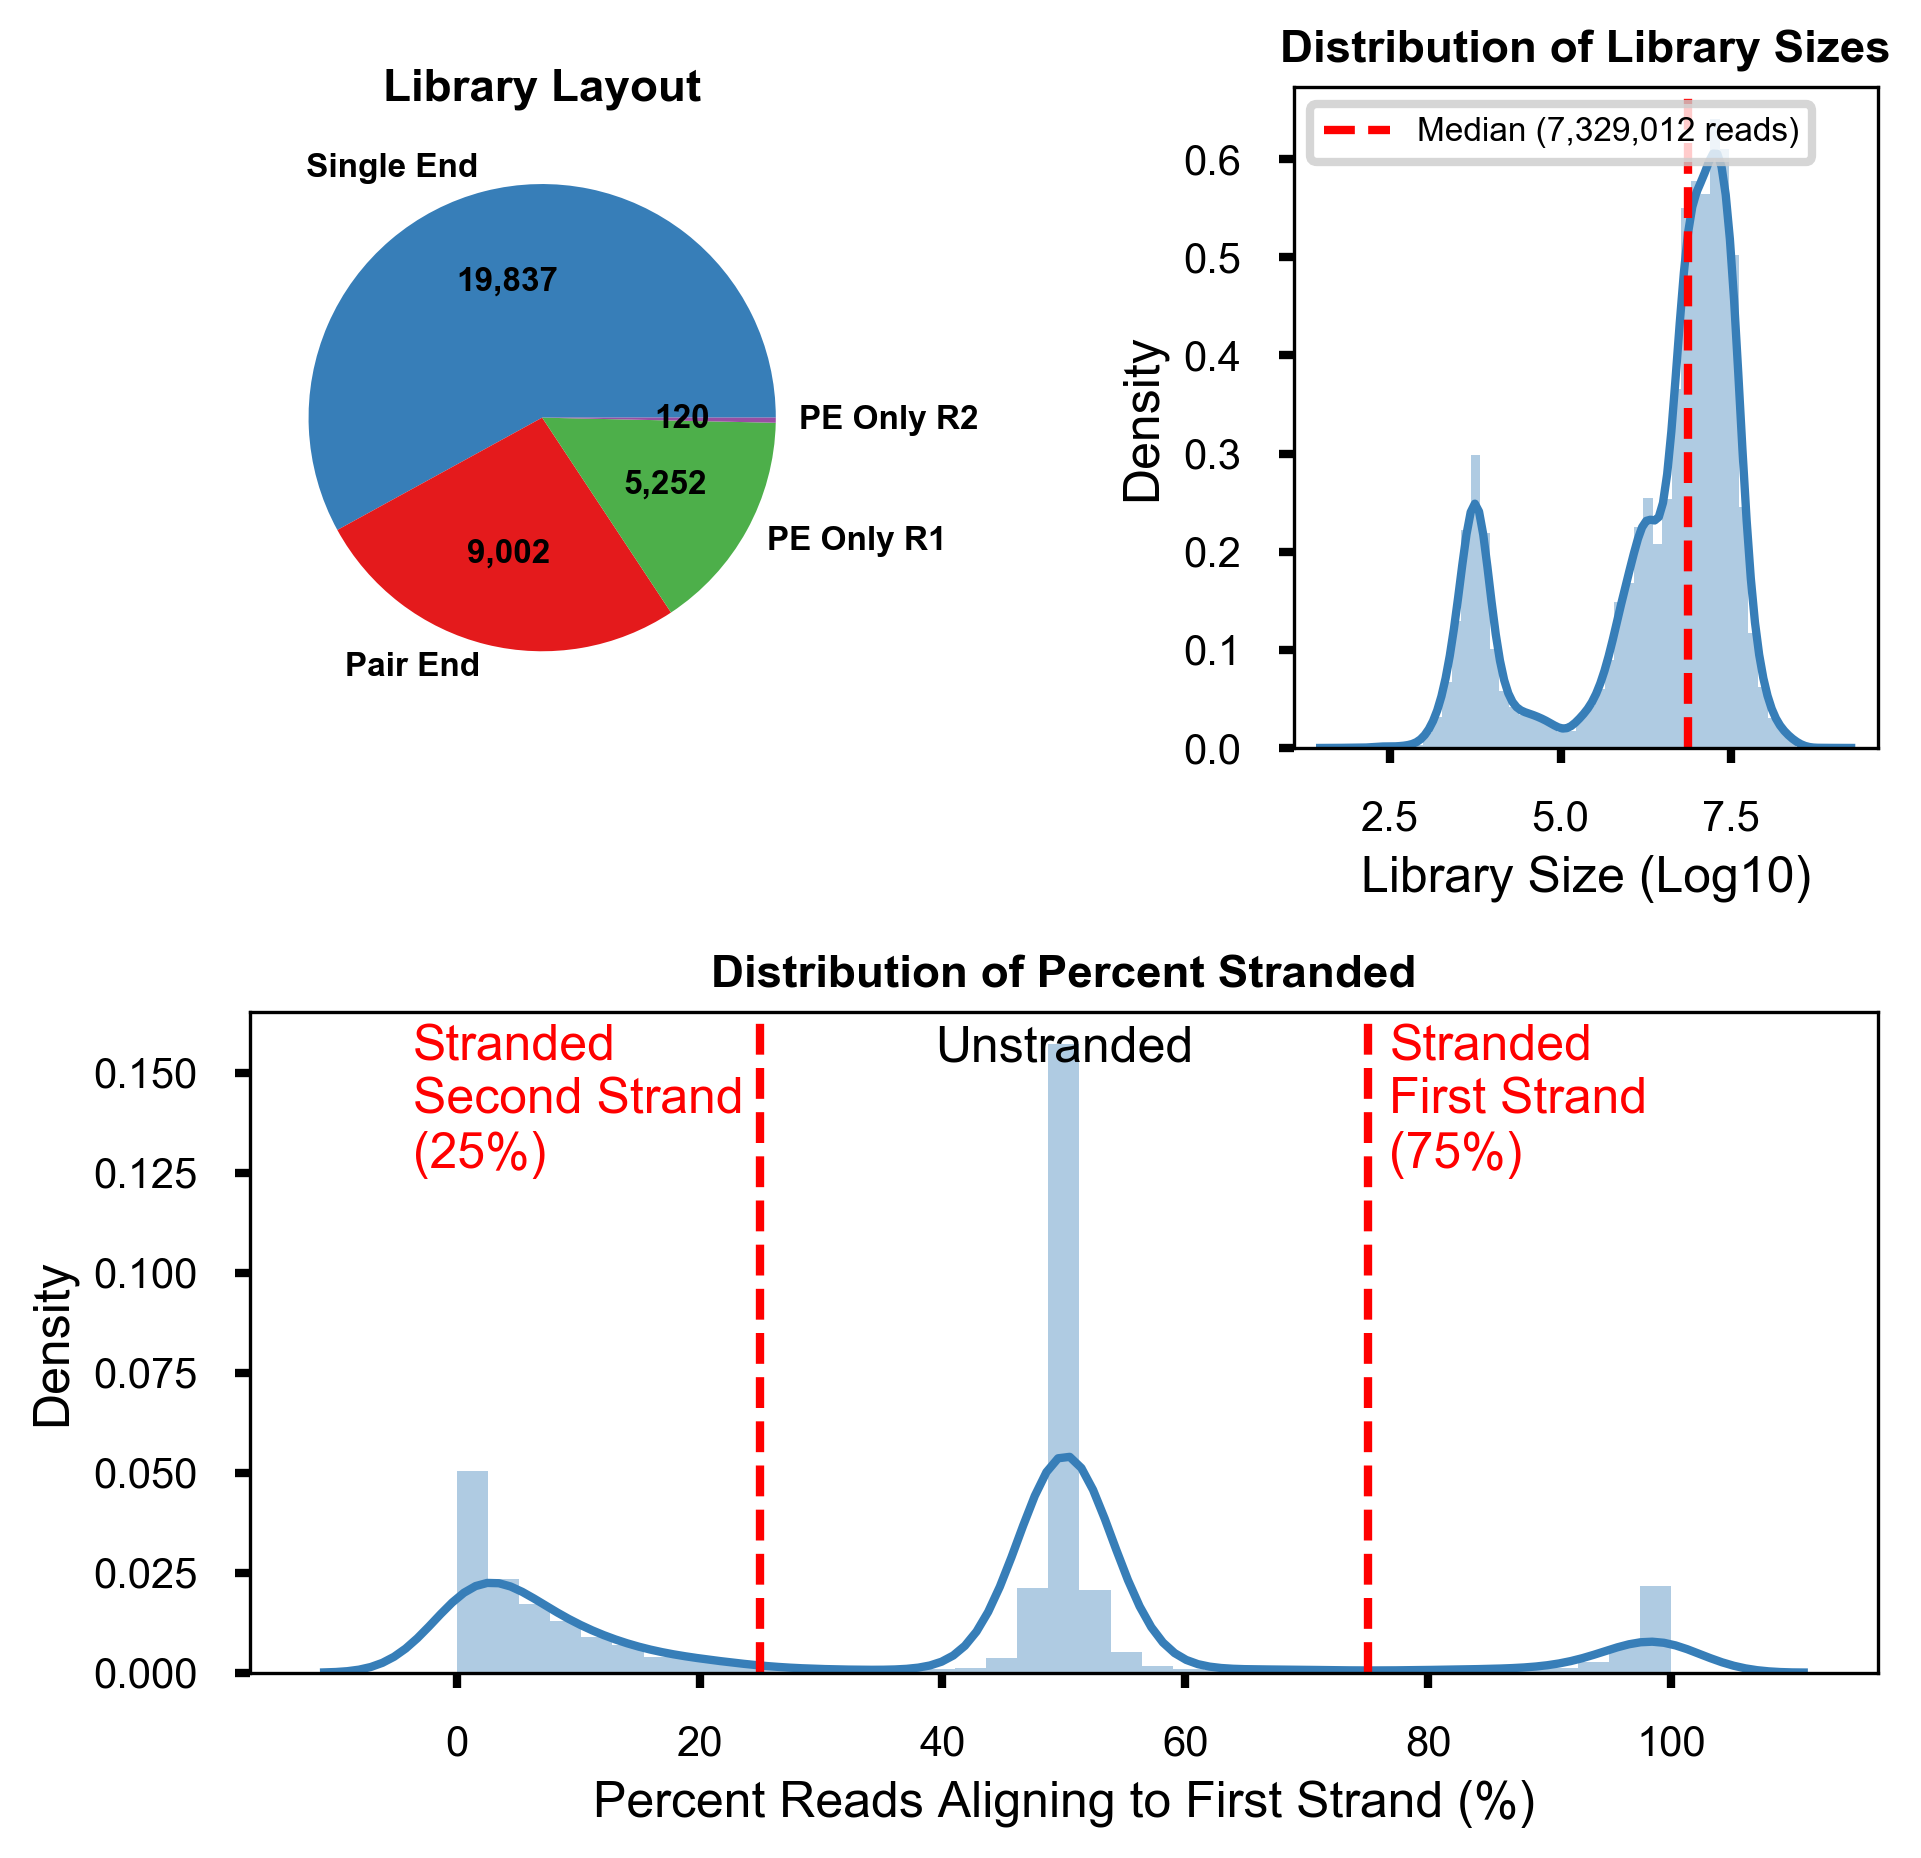

In [27]:
fig = plt.figure()
gs = plt.GridSpec(2, 3, width_ratios=[1, .2, 1], wspace=.4, hspace=.4)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, :])

# Library Layout
layout = store.select('layout', where='srx == complete').value_counts()
total = layout.sum()

mapper = dict(SE='Single End', PE='Pair End', keep_R1='PE Only R1', keep_R2='PE Only R2')
layout.index = layout.index.map(mapper)

layout.plot.pie(autopct=lambda pct: '{:,.0f}'.format(np.round(pct * total / 100, 0)), textprops=dict(fontsize=8, fontweight='bold'), ax=ax1)
ax1.set_aspect('equal')
ax1.set_ylabel('')
ax1.set_title('Library Layout')

# Library Size
_libsize = np.log10(store['prealn/workflow/fastq'][['libsize_R1', 'libsize_R2']].max(axis=1))
_med = _libsize.median()
_med_num = int(np.ceil(10**_med))

sns.distplot(np.log10(store['prealn/workflow/fastq'][['libsize_R1', 'libsize_R2']].max(axis=1)), ax=ax2)
ax2.set_xlabel('Library Size (Log10)')
ax2.set_ylabel('Density')
ax2.set_title('Distribution of Library Sizes')
ax2.axvline(_med, color='r', ls='--', label=f'Median ({_med_num:,} reads)')
ax2.legend(loc='upper left')

# Library Strandedness
_strand = store['prealn/workflow/collectrnaseqmetrics/first'].PCT_CORRECT_STRAND_READS * 100

sns.distplot(_strand, ax=ax3)
ax3.axvline(25, ls='--', color='r')
ax3.axvline(75, ls='--', color='r')

defaults = dict(va='top', transform=ax3.transAxes)
ax3.text(0.5, .98, 'Unstranded', ha='center', **defaults)
ax3.text(0.10, .98, 'Stranded\nSecond Strand\n(25%)', ha='left', color='r', **defaults)
ax3.text(0.7, .98, 'Stranded\nFirst Strand\n(75%)', ha='left', color='r', **defaults)
ax3.set_xlabel('Percent Reads Aligning to First Strand (%)')
ax3.set_ylabel('Density')
ax3.set_title('Distribution of Percent Stranded')

In [37]:
_layout = store['layout'].replace({'keep_R1': 'SE', 'keep_R2': 'SE'})
_map = pd.concat([store['prealn/workflow/hisat2'], _layout], axis=1)
_meds = _map.groupby('layout').per_alignment.median()

_dates = pd.DataFrame(list(ncbi.aggregate([
    {
        '$unwind': {
            'path': '$sra.run'
        }
    },
    {
        '$unwind': {
            'path': '$biosample'
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$_id',
            'srr': '$sra.run.run_id',
            'date': '$biosample.submission_date'
        }
    }
])))
_dates.date = pd.to_datetime(_dates.date, format='%Y-%m-%d')
_dates = _dates.sort_values("date").set_index(['srx', 'srr']).date

_perAln = _map.per_alignment
_perAln_w_date = pd.concat([_perAln, _dates], axis=1).dropna()

In [69]:
chroms = ['chrX', 'chr2L', 'chr2R', 'chr3L', 'chr3R', 'chr4', 'chrY', 'chrM']

@delayed
def parse_idx(srx):
    _df = pd.read_parquet(f'../output/aln-wf/samtools_idxstats/{srx}.parquet')
    _dat = _df.reindex(chroms)['# mapped reads']
    _dat.name = srx
    return _dat

work = []
for srx in complete:
    work.append(parse_idx(srx))
    
futures = daskClient.compute(work)
_map_by_chrom = pd.concat(daskClient.gather(futures), axis=1).T

In [115]:
_total = _map_by_chrom.sum(axis=1)

In [142]:
_perAln_w_chrom = _map_by_chrom.div(_total, axis=0) * 100
_perAln_w_chrom.columns = [x.lstrip('chr') for x in _perAln_w_chrom.columns]
_perAln_w_chrom.columns.name = 'chrom'

Text(0,0.5,'Percent Reads Mapping (%)')

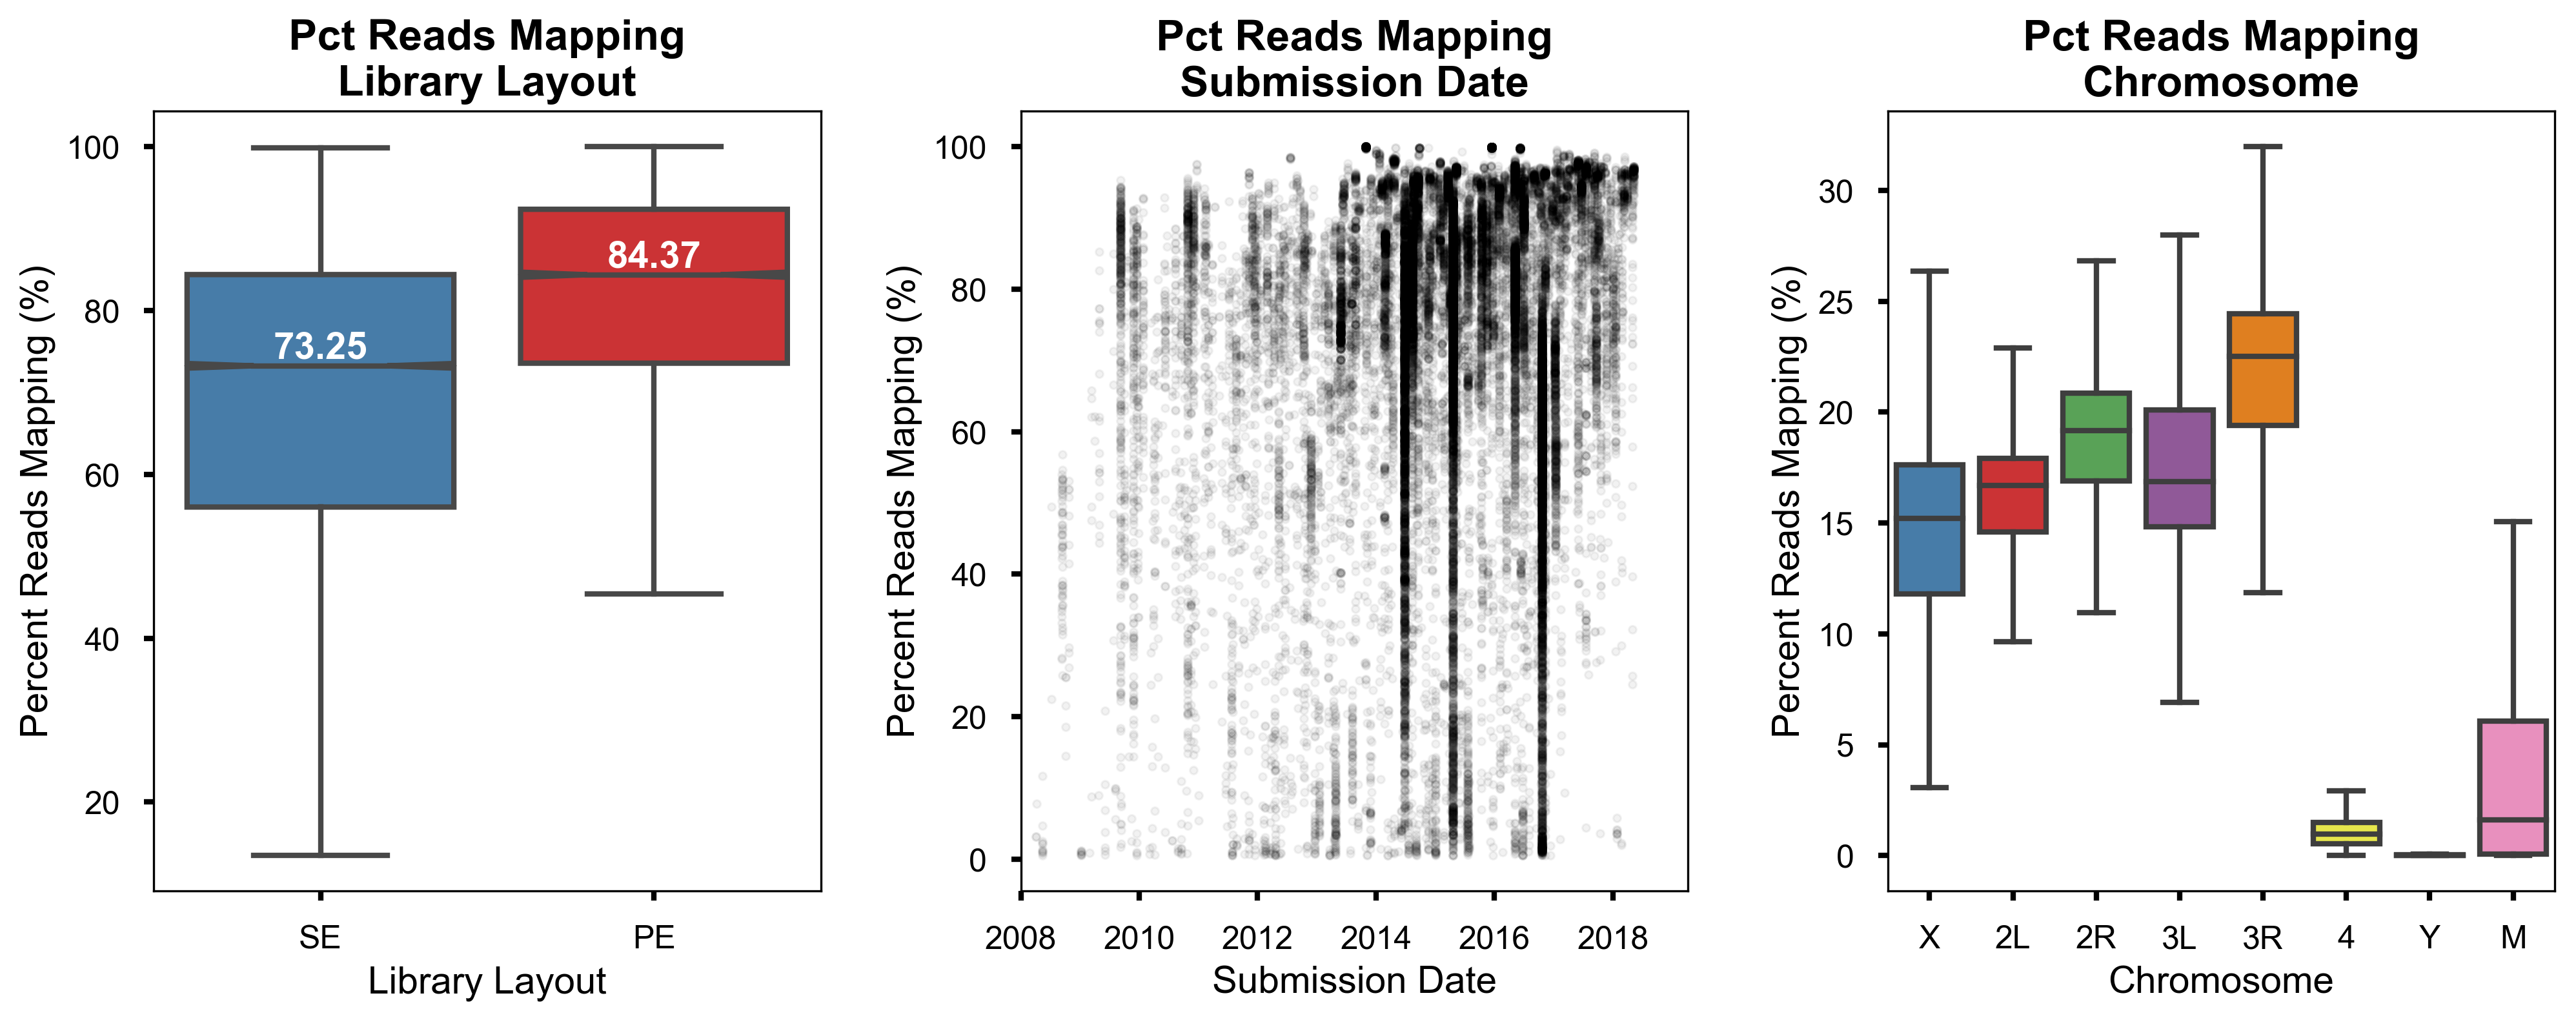

In [144]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plt.figaspect(1/3), gridspec_kw=dict(wspace=.3))
sns.boxplot('layout', 'per_alignment', data=_map, ax=ax1, showfliers=False, notch=True)
ax1.set_xlabel('Library Layout')
ax1.set_ylabel('Percent Reads Mapping (%)')
ax1.set_title('Pct Reads Mapping\nLibrary Layout')
ax1.text(0, _meds.SE, f'{_meds.SE}', color='w', ha='center', va='bottom', fontweight='bold')
ax1.text(1, _meds.PE, f'{_meds.PE}', color='w', ha='center', va='bottom', fontweight='bold')

sns.scatterplot('date', 'per_alignment', data=_perAln_w_date, s=8, alpha=0.05, ax=ax2, color='k', edgecolor='k')
ax2.set_xlim(datetime.date(2008, 1, 1), None)
ax2.set_ylabel('Percent Reads Mapping (%)')
ax2.set_xlabel('Submission Date')
ax2.set_title('Pct Reads Mapping\nSubmission Date')

sns.boxplot('chrom', 'value', data=_perAln_w_chrom.melt(), ax=ax3, showfliers=False)
ax3.set_title('Pct Reads Mapping\nChromosome')
ax3.set_xlabel('Chromosome')
ax3.set_ylabel('Percent Reads Mapping (%)')

In [50]:
metadata = pd.read_csv('../output/geo-wf/rnaseq_metadata.tsv', sep='\t')
metadata[metadata.pubmed_authors.str.contains('Oliver').fillna(False)]

In [51]:
vals = ','.join(metadata[metadata.pubmed == 22531030.0].sample_name.values)
url = f'https://www.ncbi.nlm.nih.gov/genome/gdv/browser/?context=GEO&acc={vals}'
print(url)

https://www.ncbi.nlm.nih.gov/genome/gdv/browser/?context=GEO&acc=SRX092557,SRX092558,SRX092559,SRX092560,SRX092561,SRX092562,SRX092563,SRX092564,SRX092565
